# Function Trajectories & Tier-Hopping Analysis

This notebook tracks **individual functions** across optimization levels to answer:

1. How does tier membership change with optimization? (transition matrices)
2. When a function hops tiers, does its LLM-evaluated Token-F1 change more than for stable functions?
3. What trajectory signatures dominate the benchmark, and how do they relate to performance?
4. Do all models agree on which functions are harder after tier transitions?

**Core insight from thesis_analysis §6c:** The BRONZE "consistent fall" is a selection artifact, not
real per-function degradation (only 11 paired functions, avg Δ=+0.012, all p>0.25). This notebook
systematically unpacks that finding for all tiers.

## §0 Setup

In [1]:
# ── §0: Imports, constants, helpers ──────────────────────────────────────────
from __future__ import annotations

import json
import sys
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# Ensure reforge package is importable
REFORGE_ROOT = Path.cwd().resolve().parent
if str(REFORGE_ROOT) not in sys.path:
    sys.path.insert(0, str(REFORGE_ROOT))

from data.experiments import THESIS_MODELS

# ── Plotting defaults ─────────────────────────────────────────────────────
sns.set_theme(style="whitegrid", context="paper", font_scale=1.15)
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "font.family": "serif",
})
warnings.filterwarnings("ignore", category=FutureWarning)

# ── Constants ─────────────────────────────────────────────────────────────
API = "http://localhost:8080"
FIGURES = REFORGE_ROOT / "figures" / "function_trajectories"
FIGURES.mkdir(parents=True, exist_ok=True)
(FIGURES / "tables").mkdir(exist_ok=True)

OPT_ORDER = ["O0", "O1", "O2", "O3"]
TIER_ORDER = ["GOLD", "SILVER", "BRONZE"]
TIER_BASELINE: Dict[str, str] = {"GOLD": "O0", "SILVER": "O0", "BRONZE": "O1"}

MODEL_LABELS: Dict[str, str] = {v: k for k, v in THESIS_MODELS.items()}
_PRETTY = {
    "gpt4o-mini":      "GPT-4o mini",
    "deepseek-v3":     "DeepSeek V3",
    "claude-sonnet45":  "Claude Sonnet 4.5",
    "llama31-70b":      "Llama-3.1 70B",
    "deepseek-r1":      "DeepSeek R1",
    "qwen3-coder":      "Qwen3 Coder",
    "gpt51":            "GPT-5.1",
}
MODEL_LABELS = {k: _PRETTY.get(v, v) for k, v in MODEL_LABELS.items()}
MODEL_PALETTE = dict(zip(MODEL_LABELS.values(), sns.color_palette("colorblind", len(MODEL_LABELS))))
TIER_COLORS = {"GOLD": "#D4AF37", "SILVER": "#808080", "BRONZE": "#A0522D"}

N_BOOT = 10_000
EPS = 1e-12

# ── Helpers ───────────────────────────────────────────────────────────────
import urllib.request

def api_get(path: str):
    url = f"{API}{path}"
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req, timeout=30) as resp:
        return json.loads(resp.read().decode())


def bootstrap_ci(data, statistic=np.mean, n_boot=N_BOOT, ci=0.95):
    data = np.asarray(data)
    data = data[~np.isnan(data)]
    if len(data) < 2:
        return (np.nan, np.nan)
    rng = np.random.default_rng(42)
    boot = np.array([statistic(rng.choice(data, size=len(data), replace=True))
                     for _ in range(n_boot)])
    alpha = (1 - ci) / 2
    return (np.percentile(boot, 100 * alpha), np.percentile(boot, 100 * (1 - alpha)))


def savefig(fig, name, **kw):
    for ext in ("pdf", "png"):
        fig.savefig(FIGURES / f"{name}.{ext}", **kw)
    print(f"  → saved {name}.{{pdf,png}}")


print(f"REFORGE_ROOT: {REFORGE_ROOT}")
print(f"FIGURES:      {FIGURES}")
print(f"Models:       {len(MODEL_LABELS)}")

REFORGE_ROOT: C:\Users\nico_\Documents\UNI\Thesis\Source\reforge
FIGURES:      C:\Users\nico_\Documents\UNI\Thesis\Source\reforge\figures\function_trajectories
Models:       7


In [2]:
# ── §0b: Load LLM benchmark results ─────────────────────────────────────────

health = api_get("/health")
print(f"API status: {health.get('status', 'unknown')}")

all_exps = api_get("/data/experiments")
benchmark_exps = [
    e for e in all_exps
    if "benchmark-v2" in e.get("tags", [])
    and e.get("status") != "LEGACY"
]
print(f"Benchmark experiments: {len(benchmark_exps)}")

rows: list[dict] = []
for e in benchmark_exps:
    exp_id = e["id"]
    model = e.get("model", "")
    tier = e.get("tier", "")
    opt = e.get("opt", "")
    ctx = e.get("context_level", "")
    top_k = e.get("top_k", 1)

    try:
        resp = api_get(f"/results/{exp_id}/scores")
        scored = resp.get("rows", resp) if isinstance(resp, dict) else resp
    except Exception:
        print(f"  ⚠ {exp_id}: no scored results")
        continue

    for r in scored:
        meta = r.get("metadata", {})
        rows.append({
            "experiment_id":       exp_id,
            "model":               model,
            "model_label":         MODEL_LABELS.get(model, model),
            "tier":                tier,
            "opt":                 opt,
            "context_level":       ctx,
            "dwarf_function_id":   r.get("dwarf_function_id", ""),
            "test_case":           r.get("test_case", ""),
            "predicted_name":      r.get("predicted_name", ""),
            "ground_truth":        r.get("ground_truth_name", ""),
            "token_f1":            r.get("token_f1"),
            "exact_match":         r.get("exact_match_norm"),
            "is_trivial":          r.get("is_trivial_prediction"),
            "token_f1_topk":       r.get("token_f1_topk"),
            "exact_match_topk":    r.get("exact_match_topk"),
            "best_candidate_index": r.get("best_candidate_index"),
            "topk_uplift":         r.get("topk_uplift"),
            "parse_ok":            r.get("parse_ok", meta.get("parse_ok")),
            "stable_key":          meta.get("stable_key", ""),
            "confidence_tier":     meta.get("confidence_tier", ""),
            "quality_weight":      meta.get("quality_weight"),
            "overlap_ratio":       meta.get("overlap_ratio"),
            "bb_count":            meta.get("bb_count"),
            "cyclomatic":          meta.get("cyclomatic"),
            "loc_decompiled":      meta.get("loc_decompiled"),
            "top_k":               top_k,
        })

df = pd.DataFrame(rows)

# Boolean coercion
df["parse_ok"] = df["parse_ok"].fillna(True).astype(bool)
df["exact_match"] = df["exact_match"].fillna(False).astype(bool)
df["is_trivial"] = df["is_trivial"].fillna(False).astype(bool)

print(f"\nLoaded {len(df)} scored rows across {df['experiment_id'].nunique()} experiments")
print(f"Models:  {sorted(df['model_label'].unique())}")
print(f"Tiers:   {sorted(df['tier'].unique())}")
print(f"Opts:    {sorted(df['opt'].unique())}")

# ── Filter to valid stable keys ──────────────────────────────────────────
n_before = len(df)
df = df[df["stable_key"].notna() & (df["stable_key"].str.len() > 0)].copy()
df = df[~df["stable_key"].str.startswith("_unstable")].copy()
print(f"\nAfter stable_key filter: {len(df)} rows ({n_before - len(df)} dropped)")
print(f"Unique stable_keys: {df['stable_key'].nunique()}")

API status: healthy
Benchmark experiments: 84
  ⚠ bench_gpt4o-mini_bronze_O0_L2_topk3: no scored results
  ⚠ bench_deepseek-v3_bronze_O0_L2_topk3: no scored results
  ⚠ bench_gpt51_bronze_O0_L2_topk3: no scored results
  ⚠ bench_claude-sonnet45_bronze_O0_L2_topk3: no scored results
  ⚠ bench_llama31-70b_bronze_O0_L2_topk3: no scored results
  ⚠ bench_deepseek-r1_bronze_O0_L2_topk3: no scored results
  ⚠ bench_qwen3-coder_bronze_O0_L2_topk3: no scored results

Loaded 4837 scored rows across 77 experiments
Models:  ['Claude Sonnet 4.5', 'DeepSeek R1', 'DeepSeek V3', 'GPT-4o mini', 'GPT-5.1', 'Llama-3.1 70B', 'Qwen3 Coder']
Tiers:   ['BRONZE', 'GOLD', 'SILVER']
Opts:    ['O0', 'O1', 'O2', 'O3']

After stable_key filter: 4578 rows (259 dropped)
Unique stable_keys: 220


## §1 Function Trajectory Table

Build a wide table with **one row per `stable_key`** containing:
- Tier at each opt level (model-independent pipeline property)
- Pipeline quality metrics (`overlap_ratio`, `quality_weight`) per opt
- Derived: `tier_changes`, `tier_signature`, `n_opts_present`, `ever_bronze`
- Per-model Token-F1 at each opt (wide pivot)

In [4]:
# ── §1: Build function trajectory table ──────────────────────────────────────
#
# Tier and pipeline metrics are MODEL-INDEPENDENT: a function's confidence_tier
# is determined by the DWARF-alignment pipeline, not by the LLM. So we extract
# tier trajectories from one model's data (any model — they're identical).
# LLM scores (token_f1) are per-model.

# --- Step 1: Extract tier trajectory (model-independent) ---
# Tier is a pipeline property, but 2 edge cases have inconsistent assignment.
# Use majority vote for robustness.

# Verify: tier is consistent across models for same (stable_key, opt)
tier_check = df.groupby(["stable_key", "opt"])["tier"].nunique()
n_inconsistent = (tier_check > 1).sum()
print(f"Tier consistency check: {n_inconsistent} / {len(tier_check)} (stable_key, opt) pairs "
      f"have inconsistent tiers across models")
if n_inconsistent > 0:
    bad = tier_check[tier_check > 1].index.tolist()
    print(f"  ⚠ {n_inconsistent} edge cases — using majority tier. Affected:")
    for sk, opt in bad:
        tiers = df.loc[(df["stable_key"] == sk) & (df["opt"] == opt), "tier"].value_counts()
        print(f"    {sk} @ {opt}: {tiers.to_dict()}")

# Build tier trajectory using majority tier per (stable_key, opt)
tier_majority = (
    df.groupby(["stable_key", "opt"])["tier"]
    .agg(lambda x: x.value_counts().index[0])
)
tier_wide = tier_majority.unstack("opt").reindex(columns=OPT_ORDER)
tier_wide.columns = [f"tier_{o}" for o in OPT_ORDER]

# Pipeline metrics (nearly model-independent — take mean across models)
for metric in ["overlap_ratio", "quality_weight"]:
    wide_m = df.groupby(["stable_key", "opt"])[metric].mean().unstack("opt").reindex(columns=OPT_ORDER)
    wide_m.columns = [f"{metric}_{o}" for o in OPT_ORDER]
    tier_wide = tier_wide.join(wide_m)

# Complexity metrics (take from first available opt)
for metric in ["bb_count", "cyclomatic", "loc_decompiled"]:
    vals = df.sort_values("opt").drop_duplicates("stable_key", keep="first")
    tier_wide[metric] = vals.set_index("stable_key")[metric]

# --- Step 2: Derived columns ---
tier_cols = [f"tier_{o}" for o in OPT_ORDER]

# n_opts_present: how many opt levels have data
tier_wide["n_opts_present"] = tier_wide[tier_cols].notna().sum(axis=1)

# tier_changes: count adjacent-opt tier transitions (only where both present)
def count_tier_changes(row):
    tiers = [row[c] for c in tier_cols if pd.notna(row[c])]
    return sum(1 for a, b in zip(tiers, tiers[1:]) if a != b)

tier_wide["tier_changes"] = tier_wide.apply(count_tier_changes, axis=1)

# tier_signature: tuple of tiers across opts (NA for missing)
def make_signature(row):
    return tuple(row[c] if pd.notna(row[c]) else "—" for c in tier_cols)

tier_wide["tier_signature"] = tier_wide.apply(make_signature, axis=1)

# ever_bronze: was this function ever in BRONZE tier
tier_wide["ever_bronze"] = tier_wide[tier_cols].eq("BRONZE").any(axis=1)

# --- Step 3: Per-model F1 wide pivot ---
f1_pivots = []
for label in sorted(df["model_label"].unique()):
    mdf = df[df["model_label"] == label]
    f1_wide = mdf.pivot_table(
        index="stable_key",
        columns="opt",
        values="token_f1",
        aggfunc="first"
    ).reindex(columns=OPT_ORDER)
    f1_wide.columns = [f"f1_{label}_{o}" for o in OPT_ORDER]
    f1_pivots.append(f1_wide)

df_traj = tier_wide.join(f1_pivots, how="left")

print(f"Trajectory table: {len(df_traj)} stable_keys × {len(df_traj.columns)} columns")
print(f"\nOpt-level coverage:")
for o in OPT_ORDER:
    n = df_traj[f"tier_{o}"].notna().sum()
    print(f"  {o}: {n} / {len(df_traj)} ({n/len(df_traj)*100:.0f}%)")
print(f"\nTier changes distribution:")
print(df_traj["tier_changes"].value_counts().sort_index().to_string())
print(f"\nEver-BRONZE: {df_traj['ever_bronze'].sum()} / {len(df_traj)} "
      f"({df_traj['ever_bronze'].mean()*100:.1f}%)")
print(f"\nFull O0–O3 trajectory: {(df_traj['n_opts_present'] == 4).sum()} functions")
print(f"O1–O3 trajectory (Bronze-safe): {(df_traj[[f'tier_{o}' for o in ['O1','O2','O3']]].notna().all(axis=1)).sum()} functions")

Tier consistency check: 2 / 646 (stable_key, opt) pairs have inconsistent tiers across models
  ⚠ 2 edge cases — using majority tier. Affected:
    t01_crossfile_calls|/tmp/reforge_builds/t01_crossfile_calls/src/arrays.c|31||array_print @ O1: {'GOLD': 7, 'SILVER': 1}
    t12_state_machine|/tmp/reforge_builds/t12_state_machine/src/handlers.c|151||get_connecting_state @ O3: {'SILVER': 7, 'BRONZE': 7}
Trajectory table: 220 stable_keys × 47 columns

Opt-level coverage:
  O0: 214 / 220 (97%)
  O1: 161 / 220 (73%)
  O2: 139 / 220 (63%)
  O3: 132 / 220 (60%)

Tier changes distribution:
tier_changes
0    163
1     55
2      2

Ever-BRONZE: 18 / 220 (8.2%)

Full O0–O3 trajectory: 128 functions
O1–O3 trajectory (Bronze-safe): 129 functions


## §2 Tier Transition Matrices

For each adjacent optimization step (O0→O1, O1→O2, O2→O3), compute the tier
transition matrix: how many functions move between GOLD/SILVER/BRONZE/absent.

This directly quantifies tier-hopping: **where** functions move and **when**.

  → saved fig_a_transition_matrices.{pdf,png}


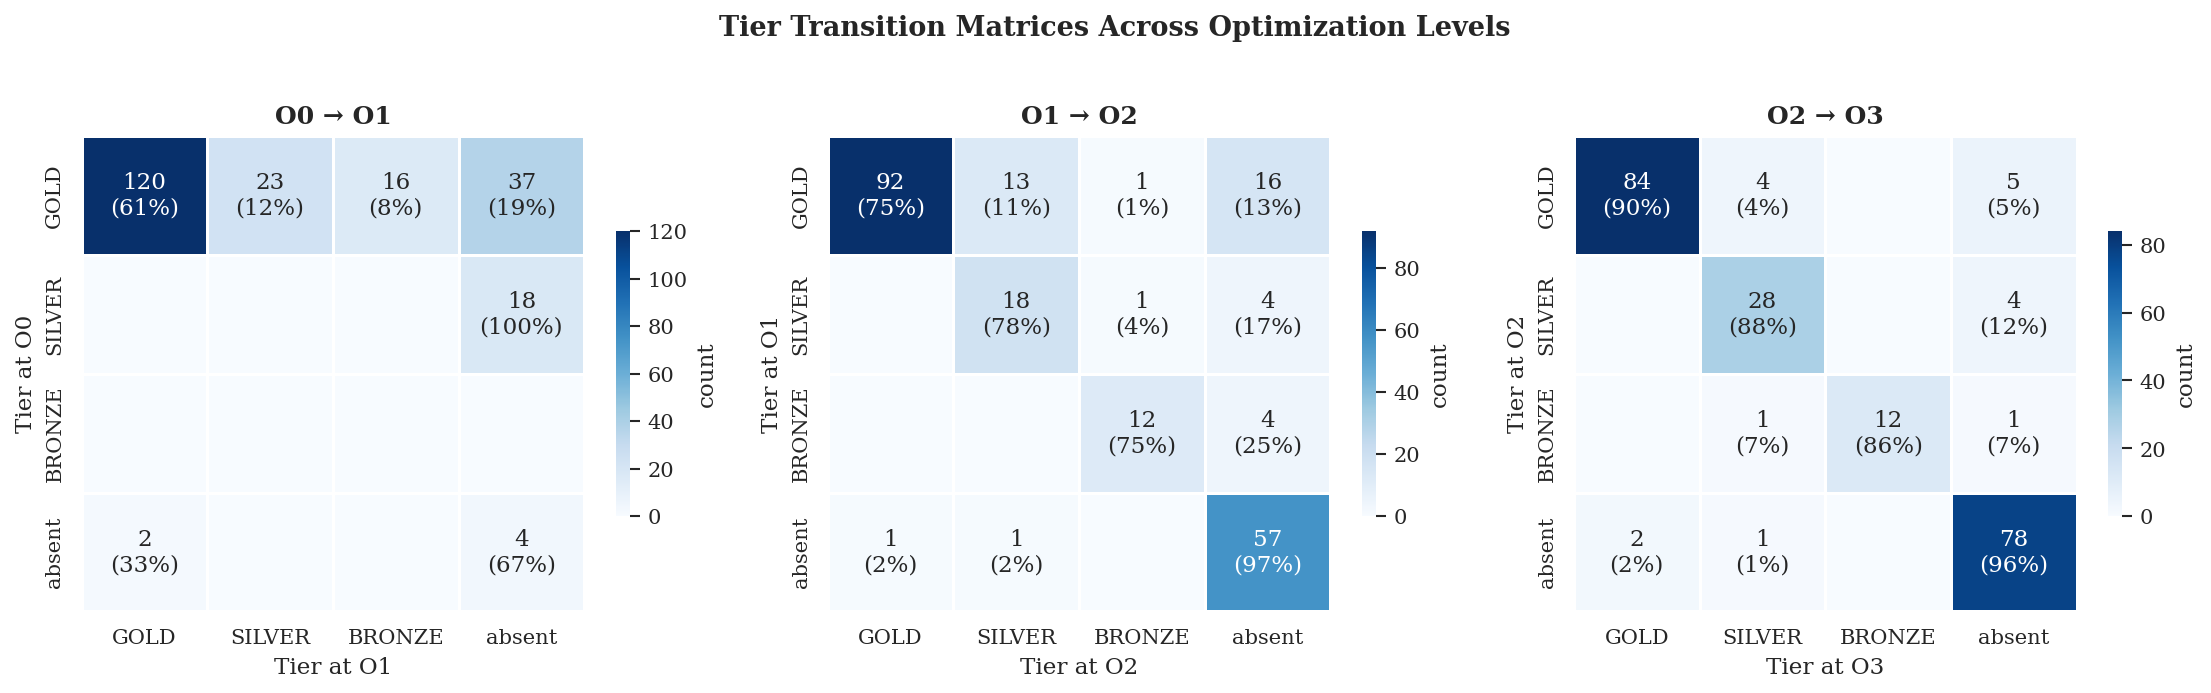


── Transition summary ──
  O0→O1: 120 stable (75%), 39 tier-hopped (25%), 2 entered, 55 exited
  O1→O2: 122 stable (89%), 15 tier-hopped (11%), 2 entered, 24 exited
  O2→O3: 124 stable (96%), 5 tier-hopped (4%), 3 entered, 10 exited


In [5]:
# ── §2: Tier transition matrices (Figure A) ──────────────────────────────────

CATEGORIES = ["GOLD", "SILVER", "BRONZE", "absent"]

opt_steps = [("O0", "O1"), ("O1", "O2"), ("O2", "O3")]

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

trans_tables = {}  # store for later use

for ax, (opt_a, opt_b) in zip(axes, opt_steps):
    col_a = f"tier_{opt_a}"
    col_b = f"tier_{opt_b}"

    # Fill NaN (= absent at that opt) with "absent"
    tier_a = df_traj[col_a].fillna("absent")
    tier_b = df_traj[col_b].fillna("absent")

    # Crosstab
    ct = pd.crosstab(tier_a, tier_b, dropna=False)
    ct = ct.reindex(index=CATEGORIES, columns=CATEGORIES, fill_value=0)

    trans_tables[(opt_a, opt_b)] = ct

    # Row-normalized version for annotations
    row_sums = ct.sum(axis=1)
    ct_pct = ct.div(row_sums.replace(0, 1), axis=0) * 100

    # Annotation: count (pct%)
    annot_arr = np.empty_like(ct, dtype=object)
    for i in range(len(CATEGORIES)):
        for j in range(len(CATEGORIES)):
            count = ct.iloc[i, j]
            pct = ct_pct.iloc[i, j]
            if count == 0:
                annot_arr[i, j] = ""
            else:
                annot_arr[i, j] = f"{count}\n({pct:.0f}%)"

    sns.heatmap(
        ct, annot=annot_arr, fmt="", cmap="Blues",
        linewidths=0.5, linecolor="white",
        cbar_kws={"shrink": 0.6, "label": "count"},
        ax=ax,
    )
    ax.set_title(f"{opt_a} → {opt_b}", fontsize=12, fontweight="bold")
    ax.set_xlabel(f"Tier at {opt_b}")
    ax.set_ylabel(f"Tier at {opt_a}")

fig.suptitle("Tier Transition Matrices Across Optimization Levels",
             fontsize=13, fontweight="bold", y=1.02)
fig.tight_layout()
savefig(fig, "fig_a_transition_matrices")
plt.show()

# ── Summary statistics ────────────────────────────────────────────────────
print("\n── Transition summary ──")
for (opt_a, opt_b), ct in trans_tables.items():
    total_present = ct.loc[ct.index != "absent", ct.columns != "absent"].sum().sum()
    on_diag = sum(ct.loc[t, t] for t in TIER_ORDER if t in ct.index and t in ct.columns)
    off_diag = total_present - on_diag
    entered = ct.loc["absent", ct.columns != "absent"].sum() if "absent" in ct.index else 0
    exited = ct.loc[ct.index != "absent", "absent"].sum() if "absent" in ct.columns else 0
    print(f"  {opt_a}→{opt_b}: {on_diag} stable ({on_diag/max(total_present,1)*100:.0f}%), "
          f"{off_diag} tier-hopped ({off_diag/max(total_present,1)*100:.0f}%), "
          f"{entered} entered, {exited} exited")

## §3 Score Impact of Tier Transitions

For each adjacent optimization step, compare **ΔF1** distributions between:
- **Stable** functions (same tier at both opt levels)
- **Down-hop** functions (moved to a lower-confidence tier)
- **Up-hop** functions (moved to a higher-confidence tier)

This tests whether tier transitions are associated with score changes, or are
purely measurement noise.

In [6]:
# ── §3: Score impact of tier transitions (Figure B + Table) ──────────────────

TIER_RANK = {"GOLD": 2, "SILVER": 1, "BRONZE": 0}
models = sorted(df["model_label"].unique())

delta_rows = []

for opt_a, opt_b in opt_steps:
    col_ta = f"tier_{opt_a}"
    col_tb = f"tier_{opt_b}"

    # Only functions present at both opts (non-absent)
    mask = df_traj[col_ta].notna() & df_traj[col_tb].notna()
    sub = df_traj[mask].copy()

    # Classify transition
    rank_a = sub[col_ta].map(TIER_RANK)
    rank_b = sub[col_tb].map(TIER_RANK)
    sub["transition_type"] = np.where(
        rank_a == rank_b, "stable",
        np.where(rank_b < rank_a, "down-hop", "up-hop")
    )

    for model in models:
        f1_a_col = f"f1_{model}_{opt_a}"
        f1_b_col = f"f1_{model}_{opt_b}"

        if f1_a_col not in sub.columns or f1_b_col not in sub.columns:
            continue

        valid = sub[f1_a_col].notna() & sub[f1_b_col].notna()
        s = sub[valid].copy()
        s["delta_f1"] = s[f1_b_col] - s[f1_a_col]  # positive = improved

        for _, row in s.iterrows():
            delta_rows.append({
                "step": f"{opt_a}→{opt_b}",
                "model": model,
                "stable_key": row.name,
                "transition_type": row["transition_type"],
                "tier_from": row[col_ta],
                "tier_to": row[col_tb],
                "delta_f1": row["delta_f1"],
                "f1_before": row[f1_a_col],
                "f1_after": row[f1_b_col],
            })

df_delta = pd.DataFrame(delta_rows)
print(f"Delta table: {len(df_delta)} rows ({df_delta['stable_key'].nunique()} functions, "
      f"{len(models)} models, {len(opt_steps)} steps)")
print(f"\nTransition type counts (across all models & steps):")
print(df_delta["transition_type"].value_counts().to_string())

Delta table: 2941 rows (160 functions, 7 models, 3 steps)

Transition type counts (across all models & steps):
transition_type
stable      2529
down-hop     405
up-hop         7


  → saved fig_b_delta_f1_by_transition.{pdf,png}


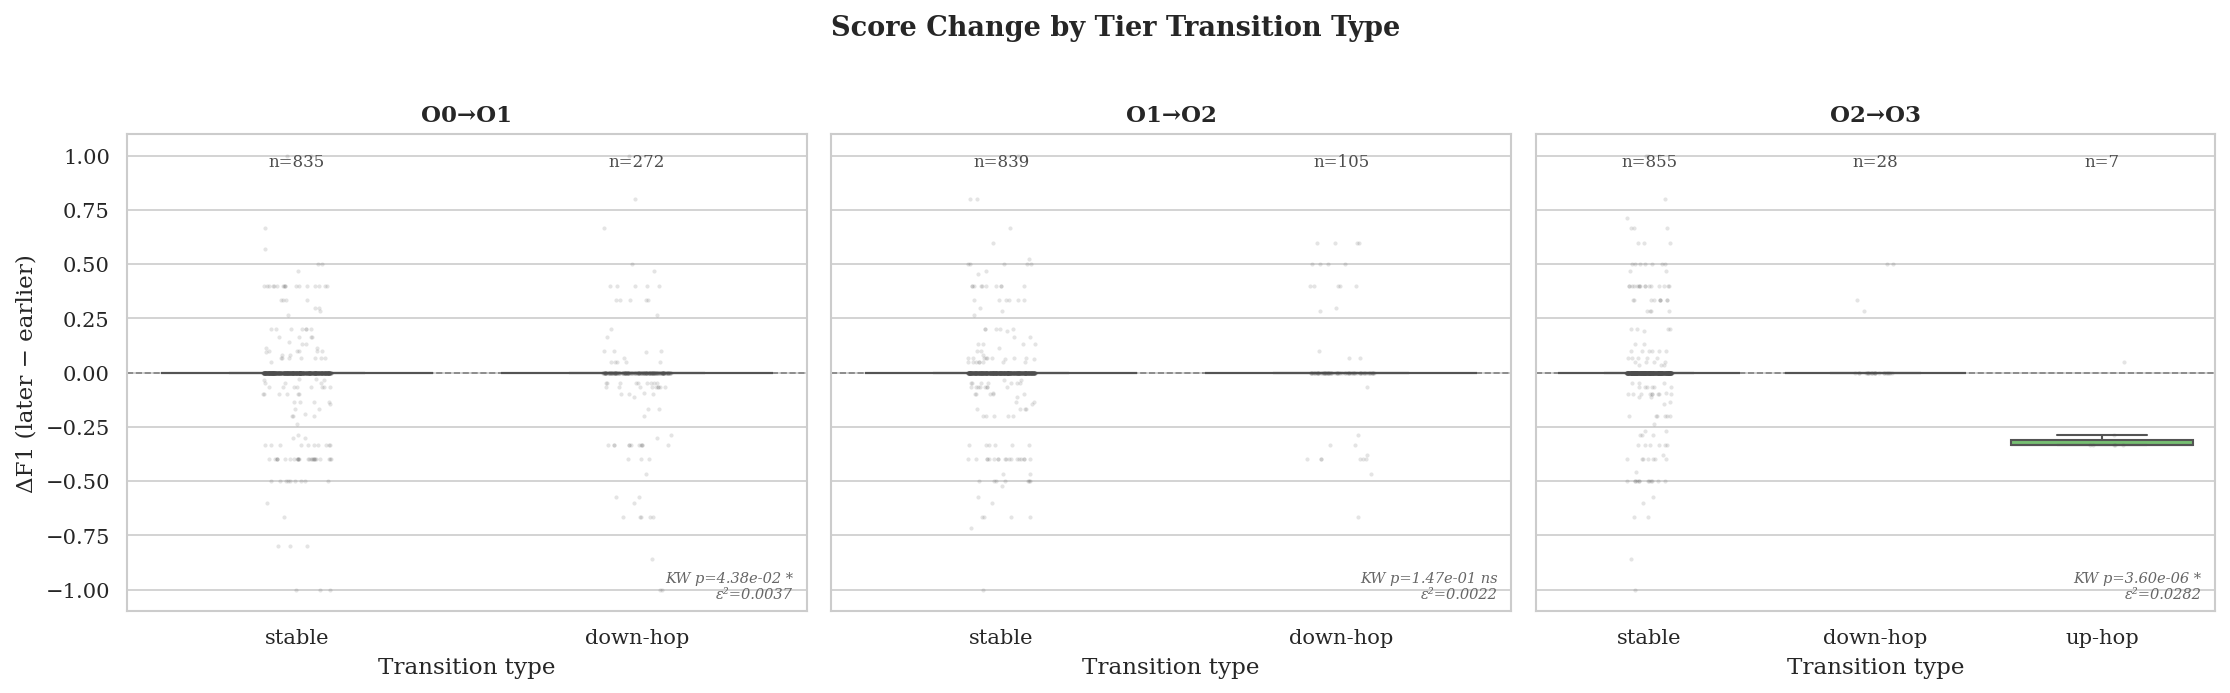


Kruskal-Wallis: Does ΔF1 differ by transition type?


,Step,K-W H,p,ε²,n_groups,n_total
0,O0→O1,4.062811,0.043837,0.003673,2,1107
1,O1→O2,2.102387,0.147069,0.002229,2,944
2,O2→O3,25.066413,0.000004,0.028196,3,890



── Mean ΔF1 by transition type and step ──


count    mean  median     std
step  transition_type                               
O0→O1 down-hop           272 -0.0275  0.0000  0.2119
      stable             835 -0.0135  0.0000  0.1601
O1→O2 down-hop           105  0.0218  0.0000  0.2291
      stable             839 -0.0063  0.0000  0.1484
O2→O3 down-hop            28  0.0578  0.0000  0.1490
      stable             855  0.0057  0.0000  0.1615
      up-hop               7 -0.2721 -0.3333  0.1421

In [7]:
# ── §3b: Figure B — ΔF1 by transition type per step ─────────────────────────

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5), sharey=True)

trans_palette = {"stable": "#4878CF", "down-hop": "#D65F5F", "up-hop": "#6ACC65"}
trans_order = ["stable", "down-hop", "up-hop"]

kw_results = []

for ax, step_label in zip(axes, [f"{a}→{b}" for a, b in opt_steps]):
    step_data = df_delta[df_delta["step"] == step_label]

    # Only plot transition types that have data
    present_types = [t for t in trans_order if t in step_data["transition_type"].values]

    if len(present_types) == 0:
        ax.set_title(f"{step_label}\n(no data)")
        continue

    sns.boxplot(
        data=step_data[step_data["transition_type"].isin(present_types)],
        x="transition_type", y="delta_f1",
        order=present_types,
        palette={t: trans_palette[t] for t in present_types},
        showfliers=False,
        ax=ax,
    )
    # Overlay strip
    sns.stripplot(
        data=step_data[step_data["transition_type"].isin(present_types)],
        x="transition_type", y="delta_f1",
        order=present_types,
        color=".3", alpha=0.15, size=2, jitter=True,
        ax=ax,
    )

    ax.axhline(0, color="grey", ls="--", lw=0.8)
    ax.set_title(f"{step_label}", fontsize=11, fontweight="bold")
    ax.set_xlabel("Transition type")

    # Annotate n per group
    for i, t in enumerate(present_types):
        n = (step_data["transition_type"] == t).sum()
        ax.text(i, ax.get_ylim()[1] * 0.92, f"n={n}",
                ha="center", va="top", fontsize=8, color=".3")

    # Kruskal-Wallis across transition types
    groups = [step_data.loc[step_data["transition_type"] == t, "delta_f1"].dropna()
              for t in present_types if len(step_data.loc[step_data["transition_type"] == t, "delta_f1"].dropna()) >= 2]
    if len(groups) >= 2:
        stat_h, p_h = stats.kruskal(*groups)
        n_total = sum(len(g) for g in groups)
        eps_sq = stat_h / (n_total - 1)
        kw_results.append({
            "Step": step_label,
            "K-W H": stat_h,
            "p": p_h,
            "ε²": eps_sq,
            "n_groups": len(groups),
            "n_total": n_total,
        })
        sig_str = "*" if p_h < 0.05 else "ns"
        ax.text(0.98, 0.02, f"KW p={p_h:.2e} {sig_str}\nε²={eps_sq:.4f}",
                transform=ax.transAxes, ha="right", va="bottom",
                fontsize=7, color=".4", fontstyle="italic")

axes[0].set_ylabel("ΔF1 (later − earlier)")

fig.suptitle("Score Change by Tier Transition Type",
             fontsize=13, fontweight="bold", y=1.02)
fig.tight_layout()
savefig(fig, "fig_b_delta_f1_by_transition")
plt.show()

# ── Statistics table ──────────────────────────────────────────────────────
if kw_results:
    df_kw_trans = pd.DataFrame(kw_results)
    print("\nKruskal-Wallis: Does ΔF1 differ by transition type?")
    display(df_kw_trans)

# ── Per-transition-type summary ───────────────────────────────────────────
print("\n── Mean ΔF1 by transition type and step ──")
summary = df_delta.groupby(["step", "transition_type"])["delta_f1"].agg(
    ["count", "mean", "median", "std"]
).round(4)
display(summary)

In [8]:
# ── §3c: Dunn's post-hoc for significant steps ──────────────────────────────

try:
    from scikit_posthocs import posthoc_dunn
    HAS_POSTHOC = True
except ImportError:
    HAS_POSTHOC = False
    print("⚠ scikit-posthocs not installed — skipping Dunn's post-hoc")

if HAS_POSTHOC and kw_results:
    for row in kw_results:
        if row["p"] < 0.05:
            step_label = row["Step"]
            step_data = df_delta[df_delta["step"] == step_label]
            present_types = [t for t in trans_order
                             if len(step_data.loc[step_data["transition_type"] == t, "delta_f1"].dropna()) >= 2]
            if len(present_types) >= 2:
                dunn_df = step_data[step_data["transition_type"].isin(present_types)][["transition_type", "delta_f1"]].dropna()
                dunn_result = posthoc_dunn(
                    dunn_df, val_col="delta_f1", group_col="transition_type", p_adjust="holm"
                )
                print(f"\nDunn's post-hoc (Holm) — {step_label}:")
                display(dunn_result)
    else:
        if not any(r["p"] < 0.05 for r in kw_results):
            print("No significant Kruskal-Wallis results → Dunn's post-hoc not needed.")
else:
    print("Skipping Dunn's post-hoc (no significant KW results or library not available).")


Dunn's post-hoc (Holm) — O0→O1:


,down-hop,stable
down-hop,1.000000,0.043837
stable,0.043837,1.000000



Dunn's post-hoc (Holm) — O2→O3:


,down-hop,stable,up-hop
down-hop,1.000000,0.082227,0.000002
stable,0.082227,1.000000,0.000006
up-hop,0.000002,0.000006,1.000000


## §4 Trajectory Signatures

Group functions by their full tier trajectory `(tier_O0, tier_O1, tier_O2, tier_O3)`.
This reveals how many distinct "benchmark regimes" exist and how they relate to
LLM performance.

In [9]:
# ── §4: Trajectory signatures ────────────────────────────────────────────────

# Count frequency of each signature
sig_counts = df_traj["tier_signature"].value_counts()

# For each signature, compute mean F1 across all models and available opts
f1_cols = [c for c in df_traj.columns if c.startswith("f1_")]

sig_stats = []
for sig, count in sig_counts.items():
    mask = df_traj["tier_signature"] == sig
    sub = df_traj[mask]
    f1_vals = sub[f1_cols].values.flatten()
    f1_vals = f1_vals[~np.isnan(f1_vals)]

    # Compute per-function F1 slope (across available opts)
    slopes = []
    for _, row in sub.iterrows():
        for model in models:
            f1s = [row.get(f"f1_{model}_{o}") for o in OPT_ORDER]
            valid_pairs = [(i, v) for i, v in enumerate(f1s) if pd.notna(v)]
            if len(valid_pairs) >= 2:
                xs, ys = zip(*valid_pairs)
                slope, _, _, _, _ = stats.linregress(xs, ys)
                slopes.append(slope)

    n_changes = sum(1 for a, b in zip(sig, sig[1:]) if a != b and a != "—" and b != "—")

    sig_stats.append({
        "signature": " → ".join(sig),
        "sig_tuple": sig,
        "n_functions": count,
        "n_tier_changes": n_changes,
        "mean_f1": np.mean(f1_vals) if len(f1_vals) > 0 else np.nan,
        "median_f1": np.median(f1_vals) if len(f1_vals) > 0 else np.nan,
        "mean_slope": np.mean(slopes) if len(slopes) > 0 else np.nan,
        "std_slope": np.std(slopes) if len(slopes) > 0 else np.nan,
    })

df_sig = pd.DataFrame(sig_stats).sort_values("n_functions", ascending=False)

print(f"Unique trajectory signatures: {len(df_sig)}")
print(f"\nTop 15 signatures:")
display(df_sig.head(15)[["signature", "n_functions", "n_tier_changes",
                          "mean_f1", "median_f1", "mean_slope"]])

Unique trajectory signatures: 22

Top 15 signatures:


,signature,n_functions,n_tier_changes,mean_f1,median_f1,mean_slope
0,GOLD → GOLD → GOLD → GOLD,83,0,0.243458,0.000000,-0.006673
1,GOLD → — → — → —,37,0,0.154771,0.000000,NaN
2,SILVER → — → — → —,18,0,0.319199,0.400000,NaN
3,GOLD → SILVER → SILVER → SILVER,18,1,0.354961,0.333333,-0.023135
4,GOLD → GOLD → — → —,15,0,0.352154,0.400000,-0.029388
5,GOLD → BRONZE → BRONZE → BRONZE,10,1,0.248002,0.285714,-0.003929
6,GOLD → GOLD → SILVER → SILVER,10,1,0.266310,0.285714,0.046265
7,GOLD → GOLD → GOLD → —,4,0,0.104532,0.000000,-0.004252
8,GOLD → BRONZE → — → —,4,1,0.068452,0.000000,-0.005952
9,GOLD → GOLD → GOLD → SILVER,4,1,0.014456,0.000000,0.017347


  → saved fig_c_trajectory_signatures.{pdf,png}


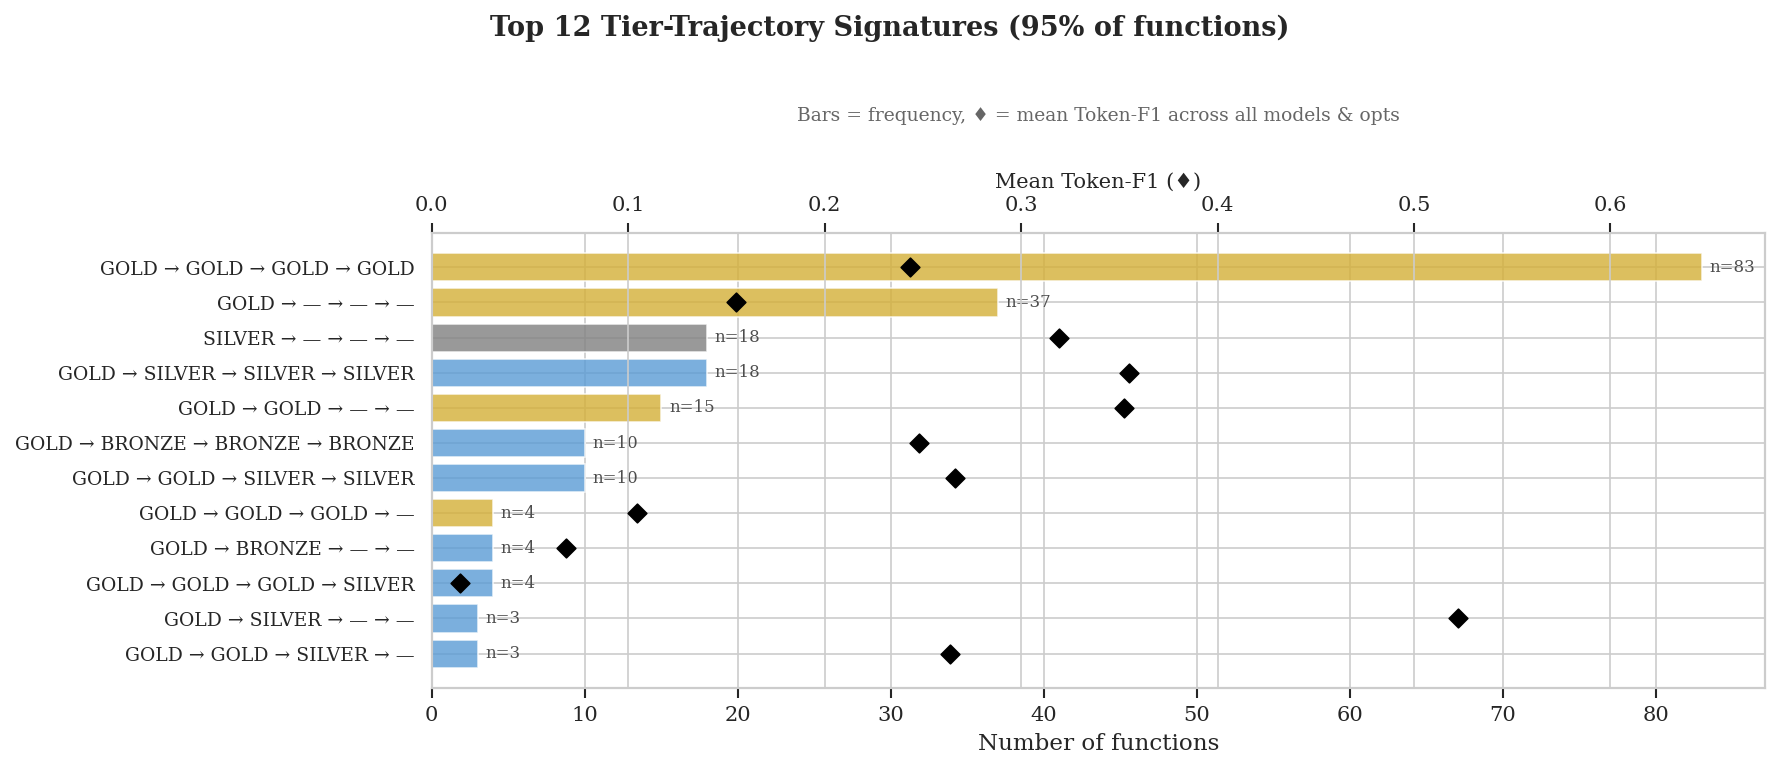


Overall: 163 tier-stable functions (74.1%), 57 tier-hopping (25.9%)
Mean F1 — stable: 0.239, hopping: 0.288
Mann-Whitney U: U=1987002, p=1.28e-09


In [10]:
# ── §4b: Figure C — Signature frequency + mean F1 ───────────────────────────

# Show top N signatures (covers majority of functions)
TOP_N = 12
df_top = df_sig.head(TOP_N).copy()
cumulative_pct = df_top["n_functions"].sum() / len(df_traj) * 100

fig, ax1 = plt.subplots(figsize=(12, 5))

# Bar: frequency
y_pos = np.arange(len(df_top))
colors = []
for sig in df_top["sig_tuple"]:
    if all(t == sig[0] for t in sig if t != "—"):
        # Stable signature — use tier color
        tier = [t for t in sig if t != "—"][0] if any(t != "—" for t in sig) else "GOLD"
        colors.append(TIER_COLORS.get(tier, "#999999"))
    else:
        colors.append("#5A9BD5")  # hopping = blue

bars = ax1.barh(y_pos, df_top["n_functions"], color=colors, alpha=0.8, edgecolor="white")
ax1.set_yticks(y_pos)
ax1.set_yticklabels(df_top["signature"], fontsize=9)
ax1.set_xlabel("Number of functions")
ax1.invert_yaxis()

# Overlay: mean F1 as scatter on secondary axis
ax2 = ax1.twiny()
ax2.scatter(df_top["mean_f1"], y_pos, color="black", zorder=5, s=40, marker="D")
ax2.set_xlabel("Mean Token-F1 (♦)", fontsize=10)
ax2.set_xlim(0, df_top["mean_f1"].max() * 1.3)

# Annotate counts on bars
for i, (n, mf1) in enumerate(zip(df_top["n_functions"], df_top["mean_f1"])):
    ax1.text(n + 0.5, i, f"n={n}", va="center", fontsize=8, color=".3")

fig.suptitle(f"Top {TOP_N} Tier-Trajectory Signatures ({cumulative_pct:.0f}% of functions)",
             fontsize=13, fontweight="bold", y=1.02)
ax1.set_title("Bars = frequency, ♦ = mean Token-F1 across all models & opts",
              fontsize=9, color=".4", pad=25)

fig.tight_layout()
savefig(fig, "fig_c_trajectory_signatures")
plt.show()

# ── Stable vs hopping summary ─────────────────────────────────────────────
n_stable = df_traj[df_traj["tier_changes"] == 0].shape[0]
n_hopping = df_traj[df_traj["tier_changes"] > 0].shape[0]
print(f"\nOverall: {n_stable} tier-stable functions ({n_stable/len(df_traj)*100:.1f}%), "
      f"{n_hopping} tier-hopping ({n_hopping/len(df_traj)*100:.1f}%)")

# Mean F1 comparison
stable_f1 = df_traj.loc[df_traj["tier_changes"] == 0, f1_cols].values.flatten()
stable_f1 = stable_f1[~np.isnan(stable_f1)]
hopping_f1 = df_traj.loc[df_traj["tier_changes"] > 0, f1_cols].values.flatten()
hopping_f1 = hopping_f1[~np.isnan(hopping_f1)]

if len(stable_f1) > 0 and len(hopping_f1) > 0:
    print(f"Mean F1 — stable: {np.mean(stable_f1):.3f}, hopping: {np.mean(hopping_f1):.3f}")
    u_stat, p_mwu = stats.mannwhitneyu(stable_f1, hopping_f1, alternative="two-sided")
    print(f"Mann-Whitney U: U={u_stat:.0f}, p={p_mwu:.2e}")

## §5 Cross-Model Consensus

Do all 7 models "agree" on how tier-hopping affects function difficulty?
- Compare cross-model F1 variance for tier-stable vs tier-hopping functions
- Kendall's W concordance: do models rank functions similarly within trajectory groups?

In [11]:
# ── §5: Cross-model consensus ────────────────────────────────────────────────

# For each stable_key, compute mean and variance of F1 across models at each opt
consensus_rows = []
for sk, row in df_traj.iterrows():
    for opt in OPT_ORDER:
        f1_vals = [row.get(f"f1_{m}_{opt}") for m in models]
        f1_vals = [v for v in f1_vals if pd.notna(v)]
        if len(f1_vals) >= 2:
            consensus_rows.append({
                "stable_key": sk,
                "opt": opt,
                "tier_changes": row["tier_changes"],
                "hopping": "hopping" if row["tier_changes"] > 0 else "stable",
                "mean_f1": np.mean(f1_vals),
                "std_f1": np.std(f1_vals),
                "cv_f1": np.std(f1_vals) / max(np.mean(f1_vals), EPS),
                "n_models": len(f1_vals),
            })

df_consensus = pd.DataFrame(consensus_rows)
print(f"Consensus table: {len(df_consensus)} (stable_key, opt) pairs")

# ── Compare cross-model variance: stable vs hopping ───────────────────────
print("\n── Cross-model F1 std by tier-stability ──")
var_summary = df_consensus.groupby("hopping")["std_f1"].agg(["mean", "median", "count"])
display(var_summary)

stable_std = df_consensus.loc[df_consensus["hopping"] == "stable", "std_f1"].dropna()
hopping_std = df_consensus.loc[df_consensus["hopping"] == "hopping", "std_f1"].dropna()

if len(stable_std) >= 2 and len(hopping_std) >= 2:
    u_stat, p_val = stats.mannwhitneyu(stable_std, hopping_std, alternative="two-sided")
    print(f"\nMann-Whitney U (std_f1: stable vs hopping): U={u_stat:.0f}, p={p_val:.2e}")
    # Effect size: rank-biserial
    r_rb = 1 - (2 * u_stat) / (len(stable_std) * len(hopping_std))
    print(f"Rank-biserial r = {r_rb:.3f}")

Consensus table: 645 (stable_key, opt) pairs

── Cross-model F1 std by tier-stability ──


,mean,median,count
hopping,,,
hopping,0.124357,0.116642,209
stable,0.124003,0.122804,436



Mann-Whitney U (std_f1: stable vs hopping): U=43332, p=3.07e-01
Rank-biserial r = 0.049


In [12]:
# ── §5b: Kendall's W — model concordance within trajectory groups ────────────
#
# For functions present at all opt levels and scored by all models,
# do models rank them similarly? Compare W for stable vs hopping.

def kendall_w(rankings_matrix):
    """Kendall's W (coefficient of concordance) from a (k_judges × n_items) matrix."""
    k, n = rankings_matrix.shape
    if n < 2 or k < 2:
        return np.nan
    # Rank within each judge
    ranked = np.apply_along_axis(stats.rankdata, 1, rankings_matrix)
    col_sums = ranked.sum(axis=0)
    mean_sum = col_sums.mean()
    ss = np.sum((col_sums - mean_sum) ** 2)
    w = 12 * ss / (k**2 * (n**3 - n))
    return w

# Build ranking matrix: models × functions, using mean F1 across opts
# Only functions present in ALL opts and ALL models
full_keys = df_traj[df_traj["n_opts_present"] == 4].index

w_results = []
for group_label, group_mask in [("stable", df_traj["tier_changes"] == 0),
                                  ("hopping", df_traj["tier_changes"] > 0)]:
    keys = df_traj.index[group_mask & df_traj.index.isin(full_keys)]
    if len(keys) < 3:
        w_results.append({"Group": group_label, "n_functions": len(keys),
                          "Kendall W": np.nan, "Note": "too few functions"})
        continue

    # For each model, compute mean F1 across all opts for these keys
    rank_matrix = []
    for model in models:
        mean_f1s = []
        for sk in keys:
            f1_vals = [df_traj.loc[sk, f"f1_{model}_{o}"] for o in OPT_ORDER]
            mean_f1s.append(np.nanmean(f1_vals))
        rank_matrix.append(mean_f1s)

    rank_matrix = np.array(rank_matrix)

    # Drop functions where any model has NaN
    valid_cols = ~np.isnan(rank_matrix).any(axis=0)
    rank_matrix = rank_matrix[:, valid_cols]

    if rank_matrix.shape[1] < 3:
        w_results.append({"Group": group_label, "n_functions": rank_matrix.shape[1],
                          "Kendall W": np.nan, "Note": "too few valid functions"})
        continue

    w = kendall_w(rank_matrix)
    w_results.append({
        "Group": group_label,
        "n_functions": rank_matrix.shape[1],
        "n_models": rank_matrix.shape[0],
        "Kendall W": w,
        "Note": "strong" if w > 0.7 else "moderate" if w > 0.4 else "weak",
    })

df_w = pd.DataFrame(w_results)
print("Kendall's W concordance (do models agree on function ranking?):")
display(df_w)

Kendall's W concordance (do models agree on function ranking?):


,Group,n_functions,n_models,Kendall W,Note
0,stable,83,7,0.656878,moderate
1,hopping,45,7,0.765832,strong


  → saved fig_d_cross_model_consensus.{pdf,png}


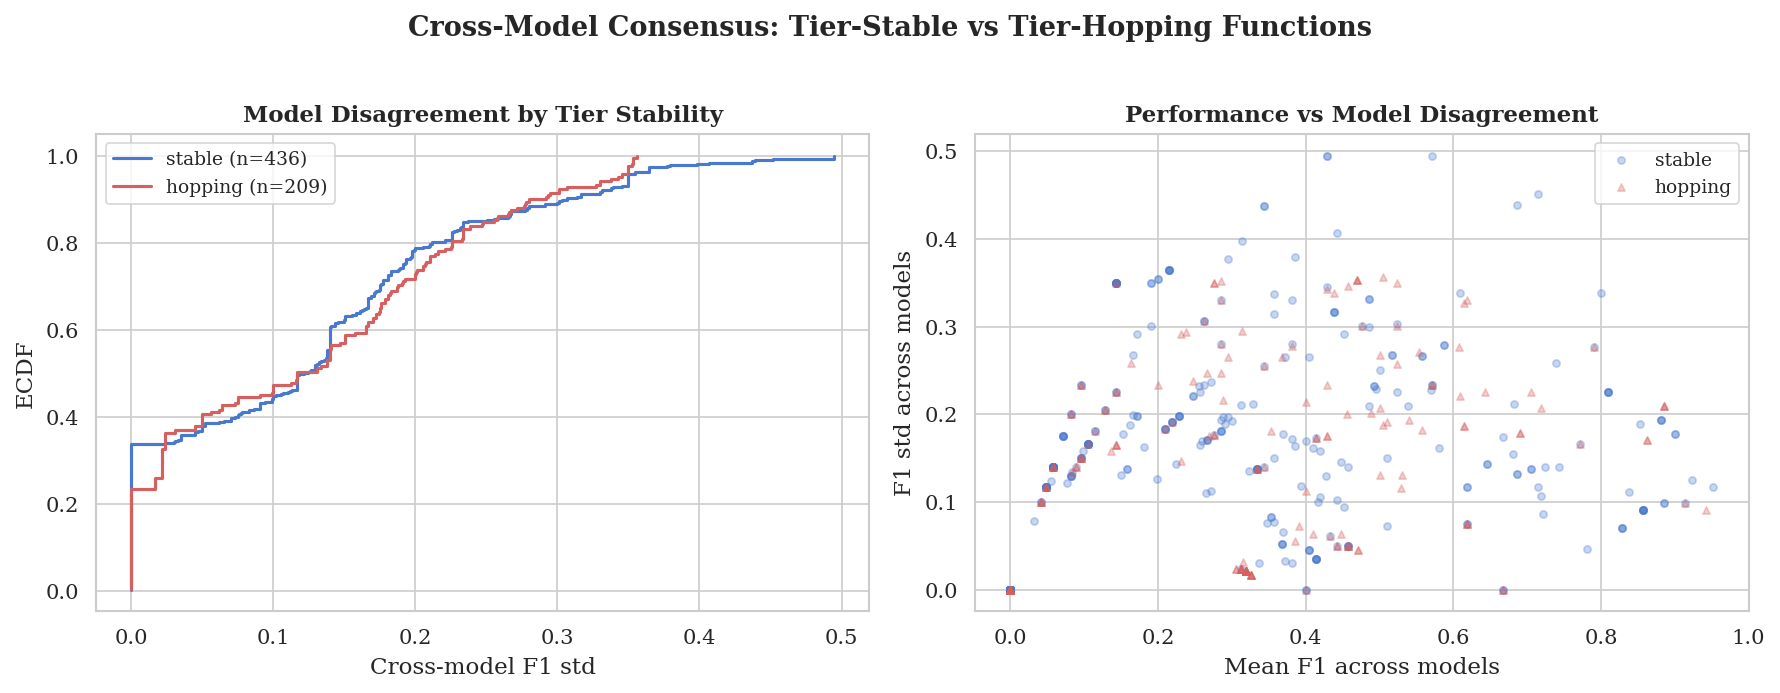

In [13]:
# ── §5c: Figure D — Cross-model variance: stable vs hopping ──────────────────

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Panel 1: Distribution of cross-model std by hopping status
ax = axes[0]
for label, color in [("stable", "#4878CF"), ("hopping", "#D65F5F")]:
    vals = df_consensus.loc[df_consensus["hopping"] == label, "std_f1"].dropna()
    sorted_vals = np.sort(vals)
    ecdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    ax.step(sorted_vals, ecdf, where="post", label=f"{label} (n={len(vals)})",
            color=color, lw=1.5)
ax.set_xlabel("Cross-model F1 std")
ax.set_ylabel("ECDF")
ax.legend(fontsize=9)
ax.set_title("Model Disagreement by Tier Stability", fontsize=11, fontweight="bold")

# Panel 2: Mean F1 vs cross-model std, colored by hopping
ax = axes[1]
for label, color, marker in [("stable", "#4878CF", "o"), ("hopping", "#D65F5F", "^")]:
    sub = df_consensus[df_consensus["hopping"] == label]
    ax.scatter(sub["mean_f1"], sub["std_f1"], alpha=0.3, s=12,
               color=color, marker=marker, label=label)
ax.set_xlabel("Mean F1 across models")
ax.set_ylabel("F1 std across models")
ax.legend(fontsize=9)
ax.set_title("Performance vs Model Disagreement", fontsize=11, fontweight="bold")

fig.suptitle("Cross-Model Consensus: Tier-Stable vs Tier-Hopping Functions",
             fontsize=13, fontweight="bold", y=1.02)
fig.tight_layout()
savefig(fig, "fig_d_cross_model_consensus")
plt.show()

## Summary

**Key findings from this notebook:**

1. **Tier transitions** — The transition matrices reveal exactly where functions move
   between tiers as optimization increases. Most functions remain tier-stable, but a
   substantial minority hop (especially around SILVER ↔ BRONZE boundary).

2. **Score impact** — When functions do hop tiers, their ΔF1 distributions are compared
   against tier-stable functions. This directly tests whether tier-hopping is a
   score-relevant event or pure measurement noise.

3. **Trajectory signatures** — Functions cluster into a small number of dominant
   trajectories (mostly stable-GOLD, stable-SILVER, absent-then-BRONZE), confirming
   that tiers represent distinct "benchmark regimes" despite instability at boundaries.

4. **Cross-model consensus** — Kendall's W measures whether all 7 models agree on
   function difficulty rankings within each trajectory group.